# Supplier Selection

The purpose of this project is to **analyze supply chain data** to gain insights into supplier performance, identify key cost drivers, and find patterns that can help optimize operations. This is achieved through a combination of data preprocessing, feature engineering, machine learning classification, and clustering analysis.

### Dataset

The dataset contains information related to a supply chain of makeup products, with features such as:

- Product Type, SKU, and Price
- Supplier Name and Location
- Stock Levels and Production Volumes
- Manufacturing Costs and Defect Rates
- Shipping Times, Costs, and Transportation Modes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, silhouette_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## 1. Data Exploration and Cleaning

In [2]:
# Extract the ZIP file
zip_file = "Supply Chain Analysis1.zip"
extract_folder = "supplier_data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Load the CSV file
data_path = f"{extract_folder}/supply_chain_data.csv"
data = pd.read_csv(data_path)

# Display the first few rows of the data
print("Data Overview:")
print(data.head())

# Summary statistics
print("\nData Summary:")
print(data.describe(include='all'))

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Data types and memory usage
print("\nData Info:")
print(data.info())

Data Overview:
  Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   
2     haircare  SKU2  11.319683            34                        8   
3     skincare  SKU3  61.163343            68                       83   
4     skincare  SKU4   4.805496            26                      871   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   
2        9577.749626               Unknown             1          10   
3        7766.836426            Non-binary            23          13   
4        2686.505152            Non-binary             5           3   

   Order quantities  ...  Location Lead time  Production volumes  \
0                96  ...    Mumbai     

#### Key Observation

- Skincare products are the most common product type.
- High variability in prices, sales, and revenue, suggesting a diverse product portfolio.
- Some products have zero stock, which may indicate out-of-stock items.
- Lead times and manufacturing times vary significantly, which could impact supply chain efficiency.
- Defect rates are generally low but vary across products.
- Costs show substantial variability, possibly due to different product categories or logistics.

### Handle Missing Values

Are there missing values in the dataset? How are we handling them?

In [ ]:
missing_values = data.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing Values (Top 10):")
    print(missing_values[missing_values > 0].sort_values(ascending=False).head(10))

    # Handle missing values
    # Numerical columns: Fill with median
    numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
    data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

    # Categorical columns: Fill with mode
    categorical_columns = data.select_dtypes(include=["object"]).columns
    data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

    # Verify that all missing values are handled
    missing_values_after = data.isnull().sum()
    print("\nMissing Values After Handling:")
    print(missing_values_after[missing_values_after > 0])
else:
    print("\nNo Missing Values Detected. Proceeding with the analysis.")

## 2. Explore and Visualize Data

Let's visualize key metrics (e.g., lead times, defect rates, shipping costs) using histograms, box plots, and correlation heatmaps.

<Figure size 1500x800 with 0 Axes>

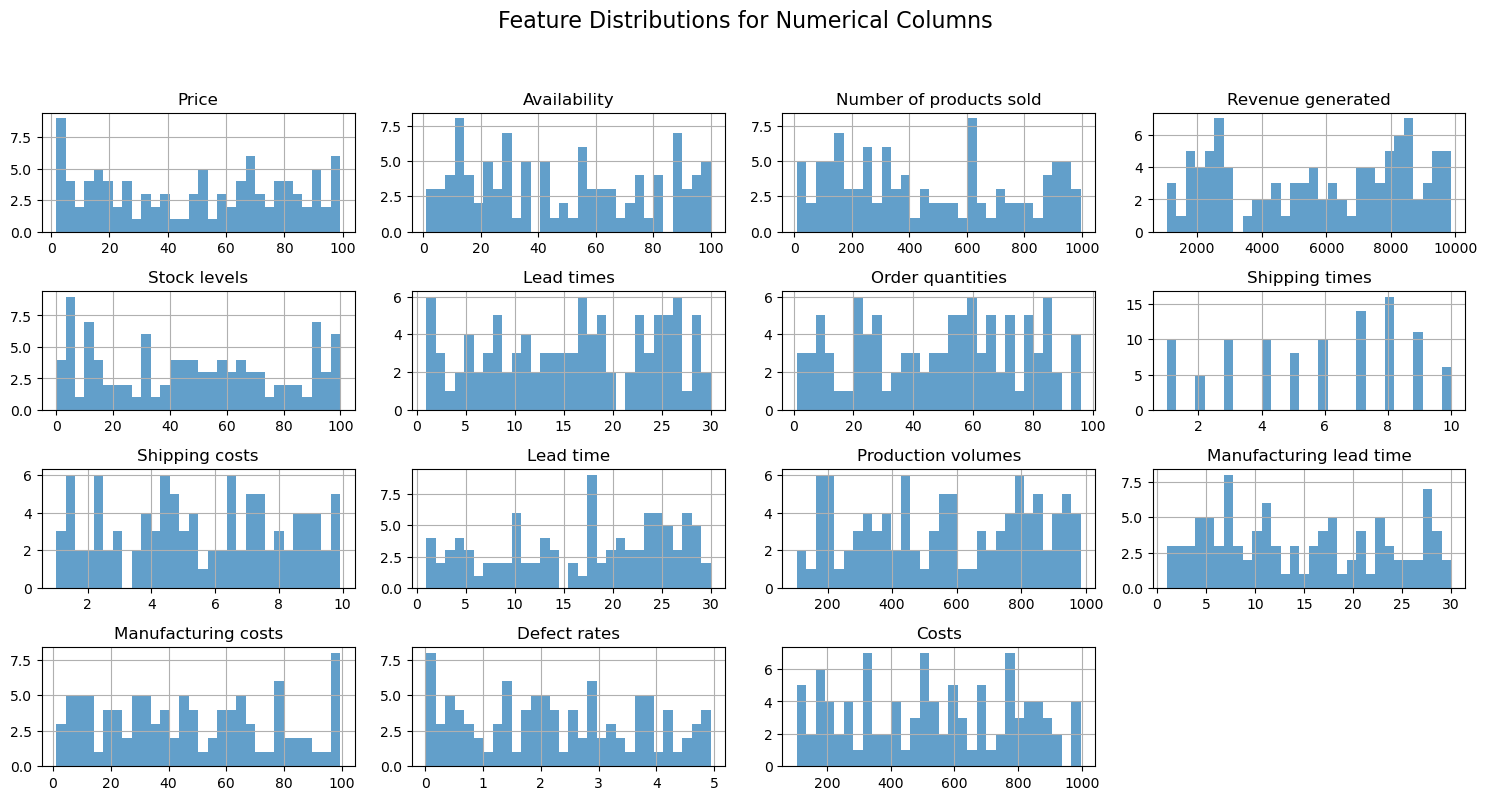

In [5]:
# What do the feature distributions look like? Are there any outliers?

numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
plt.figure(figsize=(15, 8))
data[numeric_columns].hist(bins=30, figsize=(15, 10), layout=(5, 4), alpha=0.7)
plt.suptitle("Feature Distributions for Numerical Columns", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

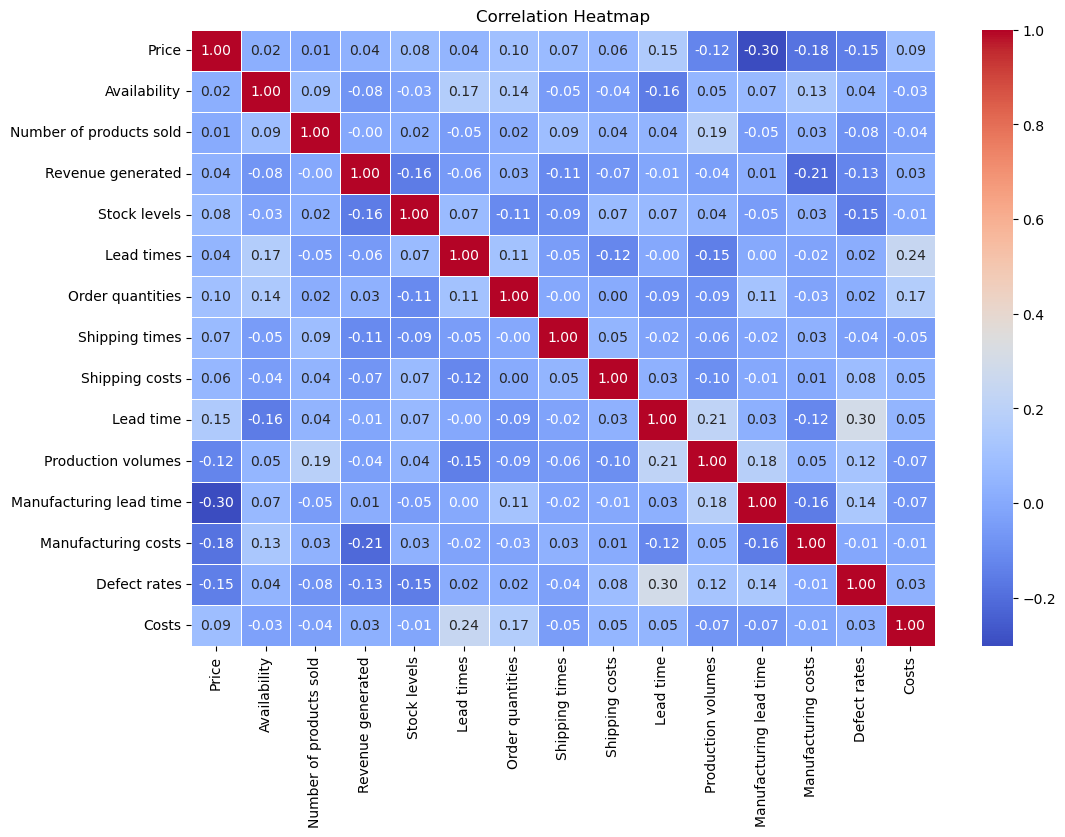

In [6]:
# Correlation heatmap for numerical columns

# How are the numerical features correlated with each other?

plt.figure(figsize=(12, 8))
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

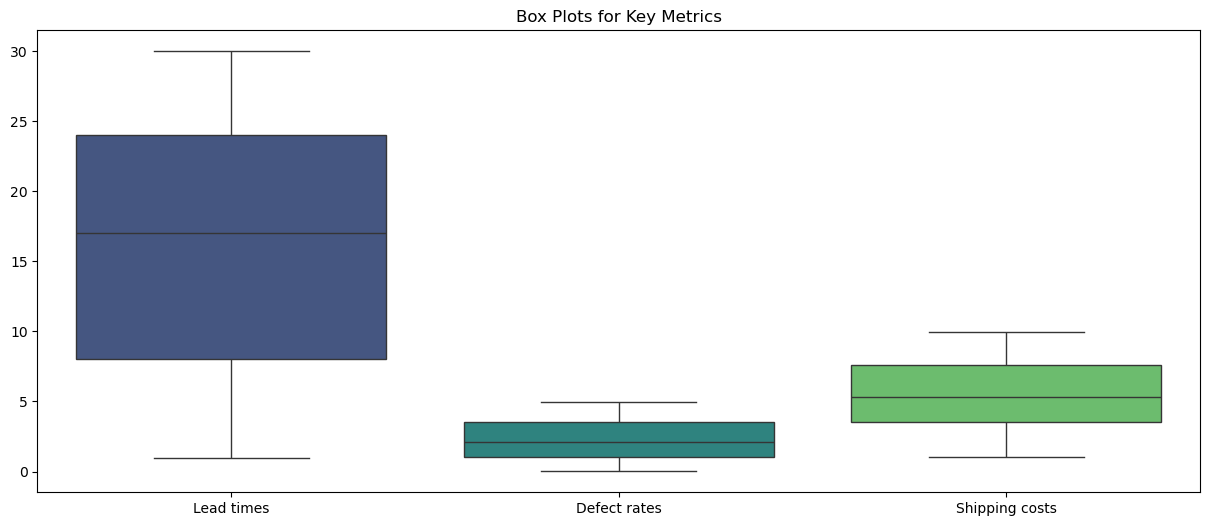

In [7]:
# How do the key metrics (e.g., lead times, defect rates, shipping costs) compare?

key_metrics = ["Lead times", "Defect rates", "Shipping costs"]
plt.figure(figsize=(15, 6))
sns.boxplot(data=data[key_metrics], palette="viridis")
plt.title("Box Plots for Key Metrics")
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_16768\386816711.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Product type", y="Shipping costs", palette="muted")


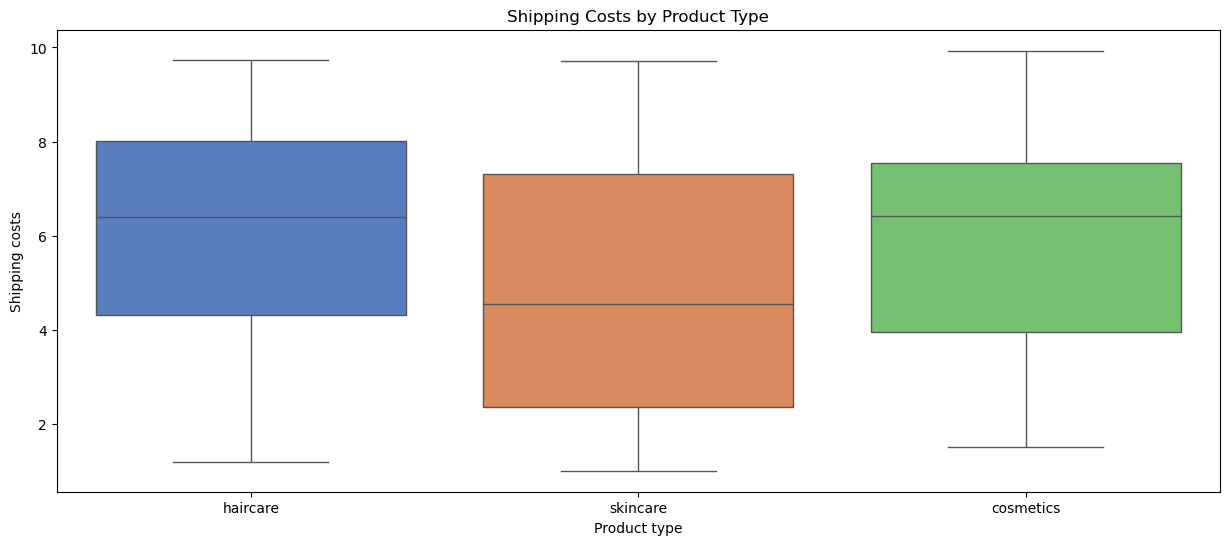

In [8]:
# How do metrics like shipping costs vary by product type?

plt.figure(figsize=(15, 6))
sns.boxplot(data=data, x="Product type", y="Shipping costs", palette="muted")
plt.title("Shipping Costs by Product Type")
plt.show()

## 3. Feature Engineering

I created new features:

- Cost per Unit: Helps in analyzing unit-level profitability.
- Defect Rate (%): Quantifies product quality.
- Lead Time Efficiency: Measures supply chain responsiveness.


New Features Overview:
   Cost per Unit  Defect Rate (%)  Lead Time Efficiency
0       0.376847         0.042231              0.198276
1       0.109544         0.982688              0.000000
2       0.050084         0.927111              0.125392
3       0.061499         0.960857              0.083744
4       0.389524         0.635480              0.465517


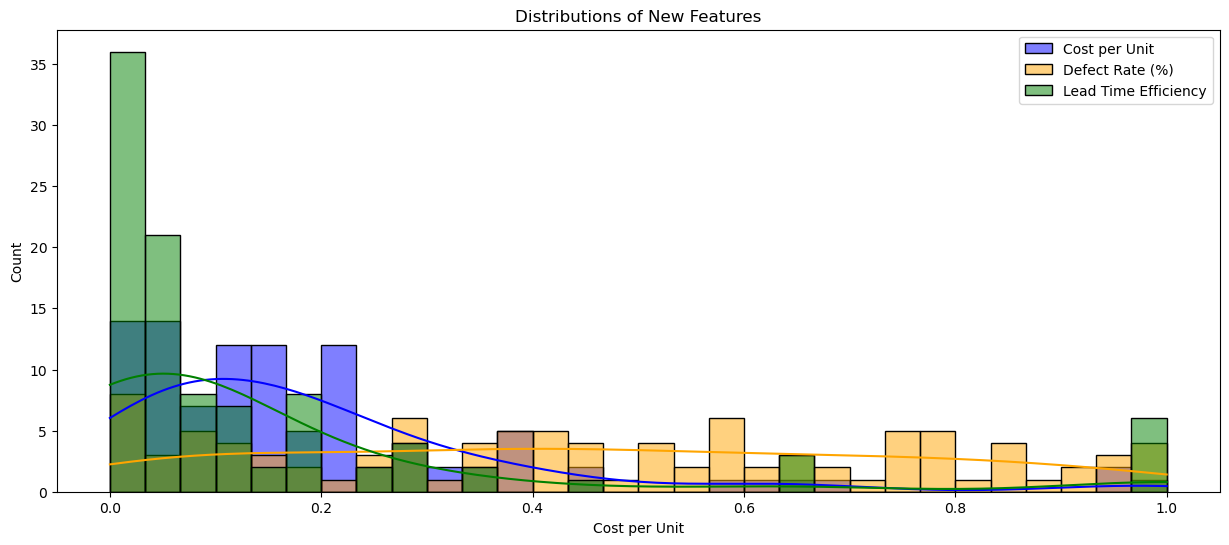

In [9]:
# Create new features
# What new features can we create that might improve model performance?

data['Cost per Unit'] = data['Manufacturing costs'] / (data['Production volumes'] + 1e-5)  # Avoid division by zero
data['Defect Rate (%)'] = data['Defect rates'] * 100
data['Lead Time Efficiency'] = 1 / (1 + data['Lead times'])  # Example transformation

# Normalize numerical features
# How do we scale the features before training the model?

scaler = MinMaxScaler()

# Dynamically select numerical columns for normalization
numerical_features = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
exclude_columns = ["Lead times", "Defect rates"]  # Columns you don't want to normalize
numerical_features = [col for col in numerical_features if col not in exclude_columns]

data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Inspect new features
print("\nNew Features Overview:")
print(data[["Cost per Unit", "Defect Rate (%)", "Lead Time Efficiency"]].head())

# Visualize new features
plt.figure(figsize=(15, 6))
sns.histplot(data["Cost per Unit"], kde=True, bins=30, color="blue", label="Cost per Unit")
sns.histplot(data["Defect Rate (%)"], kde=True, bins=30, color="orange", label="Defect Rate (%)")
sns.histplot(data["Lead Time Efficiency"], kde=True, bins=30, color="green", label="Lead Time Efficiency")
plt.title("Distributions of New Features")
plt.legend()
plt.show()

#### Key Observation

- Row 2 stands out for its low cost per unit and high defect rate, implying cost savings may be affecting product quality.
- Row 4 balances moderate cost per unit with reasonable defect rate and good lead time efficiency, indicating an overall efficient production process.

## 4. Prepare Data for Modeling

In [10]:
X = data.drop(columns=["Supplier name"])
y = data["Supplier name"]

# Encode target variable (Label Encoding)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Inspect the splits
print("\nShapes of Training and Testing Sets:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Verify encoding
print("\nEncoded Supplier Names (Sample):")
for original, encoded in zip(y[:5], y_encoded[:5]):
    print(f"{original} -> {encoded}")


Shapes of Training and Testing Sets:
X_train: (80, 26) y_train: (80,)
X_test: (20, 26) y_test: (20,)

Encoded Supplier Names (Sample):
Supplier 3 -> 2
Supplier 3 -> 2
Supplier 1 -> 0
Supplier 5 -> 4
Supplier 1 -> 0


The encoded supplier names indicate that categorical data has been numerically transformed, making it suitable for model input.

## 5. Train Machine Learning Models

In [11]:
# Define categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

In [12]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Random Forest pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = pipeline.predict(X_test)
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.35

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.40      0.29         5
           1       0.50      0.40      0.44         5
           2       1.00      0.25      0.40         4
           3       0.50      0.50      0.50         4
           4       0.00      0.00      0.00         2

    accuracy                           0.35        20
   macro avg       0.44      0.31      0.33        20
weighted avg       0.48      0.35      0.36        20



#### Key Findings

- The low accuracy and poor F1-scores suggest that the model is underfitting or the classes are imbalanced.
- The model particularly struggles with classes 0 and 4.

Consider the following steps for improvement:

- Class Balancing: Apply techniques like oversampling, undersampling, or class weighting.
- Feature Engineering: Investigate if more relevant features can be added or existing ones transformed.
- Model Complexity: Try a more complex model like Random Forest, Gradient Boosting, or Neural Networks.
- Hyperparameter Tuning: Optimize model parameters for better performance.
- Error Analysis: Investigate the misclassified samples to understand where the model is failing.

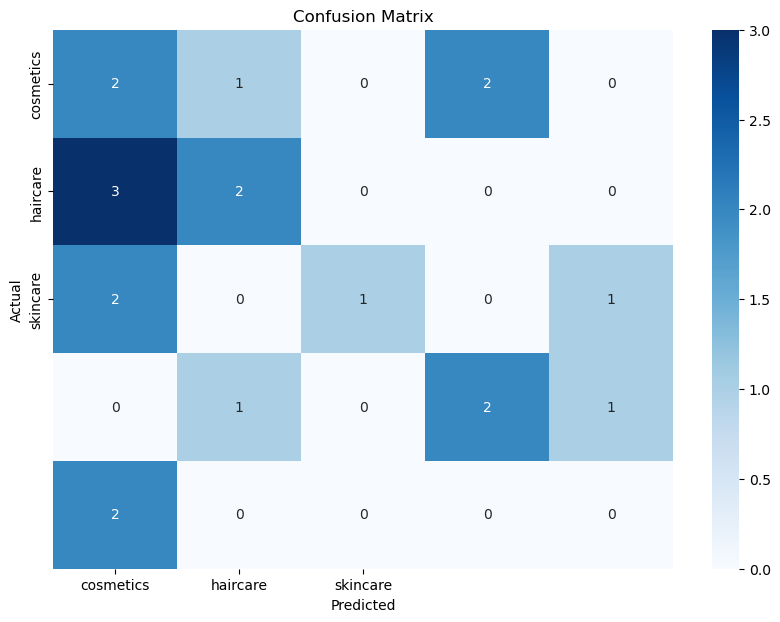

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.named_steps['preprocessor'].transformers_[1][1].categories_[0], yticklabels=pipeline.named_steps['preprocessor'].transformers_[1][1].categories_[0])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random Forest Classifier, chosen for its robustness and feature importance insights.

In [14]:
# Extract Feature Importances
rf_model = pipeline.named_steps['classifier']  # Access the RandomForestClassifier
preprocessor = pipeline.named_steps['preprocessor']  # Access the Preprocessor

# Extract numerical and one-hot encoded feature names
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

all_feature_names = numerical_features + categorical_features

In [15]:
# Map feature importances
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display Feature Importance
print("\nFeature Importance:")
print(importance_df.head())


Feature Importance:
                    Feature  Importance
0                     Price    0.051967
9                 Lead time    0.048346
1              Availability    0.047445
2   Number of products sold    0.044343
12      Manufacturing costs    0.043630


C:\Users\milto\AppData\Local\Temp\ipykernel_16768\3687486866.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


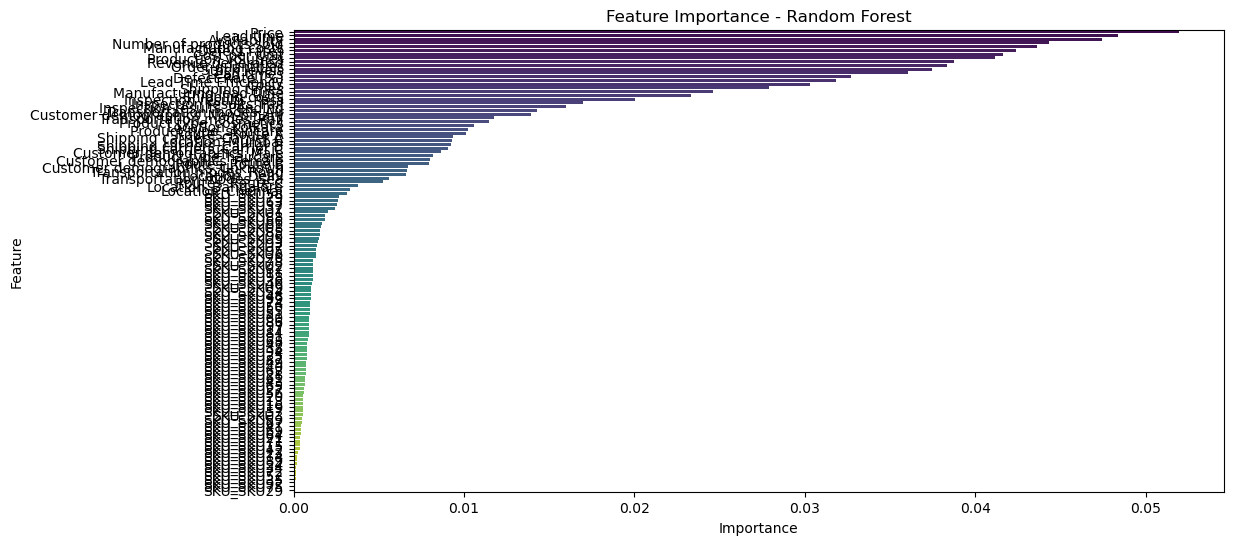

In [16]:
# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.show()

#### Key Observations

- The relatively close importance values suggest that no single feature overwhelmingly dominates the model's decisions, indicating a balanced influence from multiple factors.
- Price and Lead time are particularly strategic levers. Consider analyzing how changes in these variables impact model predictions through Partial Dependence Plots (PDPs) or SHAP values for deeper insights.
- I might want to further investigate interactions between these top features to uncover potential synergies or conflicts.
- If necessary, I can try different feature engineering techniques to enhance the predictive power of less important features or to refine the top features further.

## 6. Clustering Analysis

Segment suppliers into distinct groups for better management and strategy development, using K-Means Clustering.

#### Features Used:
- Cost per Unit
- Defect Rate (%)
- Lead Time Efficiency
- Shipping Costs

Silhouette Score to assess clustering quality.

Silhouette Score: 0.27


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


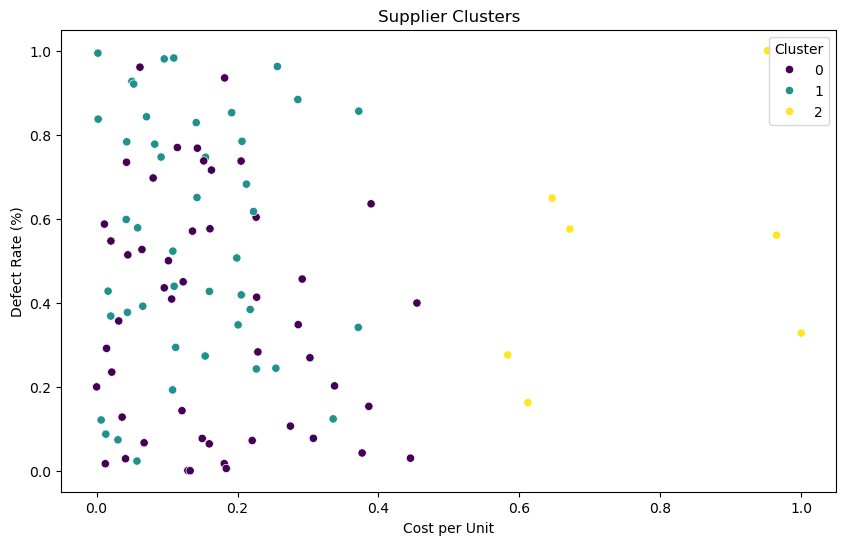

In [17]:
# Ensure clustering features are normalized
cluster_features = ["Cost per Unit", "Defect Rate (%)", "Lead Time Efficiency", "Shipping costs"]
scaler = MinMaxScaler()
data[cluster_features] = scaler.fit_transform(data[cluster_features])

# Perform K-Means clustering
# Question: Are we able to identify meaningful clusters of suppliers?

kmeans = KMeans(n_clusters=3, random_state=42)
data["Supplier Cluster"] = kmeans.fit_predict(data[cluster_features])

# Evaluate clustering quality
sil_score = silhouette_score(data[cluster_features], data["Supplier Cluster"])
print(f"Silhouette Score: {sil_score:.2f}")

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data["Cost per Unit"],
    y=data["Defect Rate (%)"],
    hue=data["Supplier Cluster"],
    palette="viridis"
)
plt.title("Supplier Clusters")
plt.xlabel("Cost per Unit")
plt.ylabel("Defect Rate (%)")
plt.legend(title="Cluster")
plt.show()

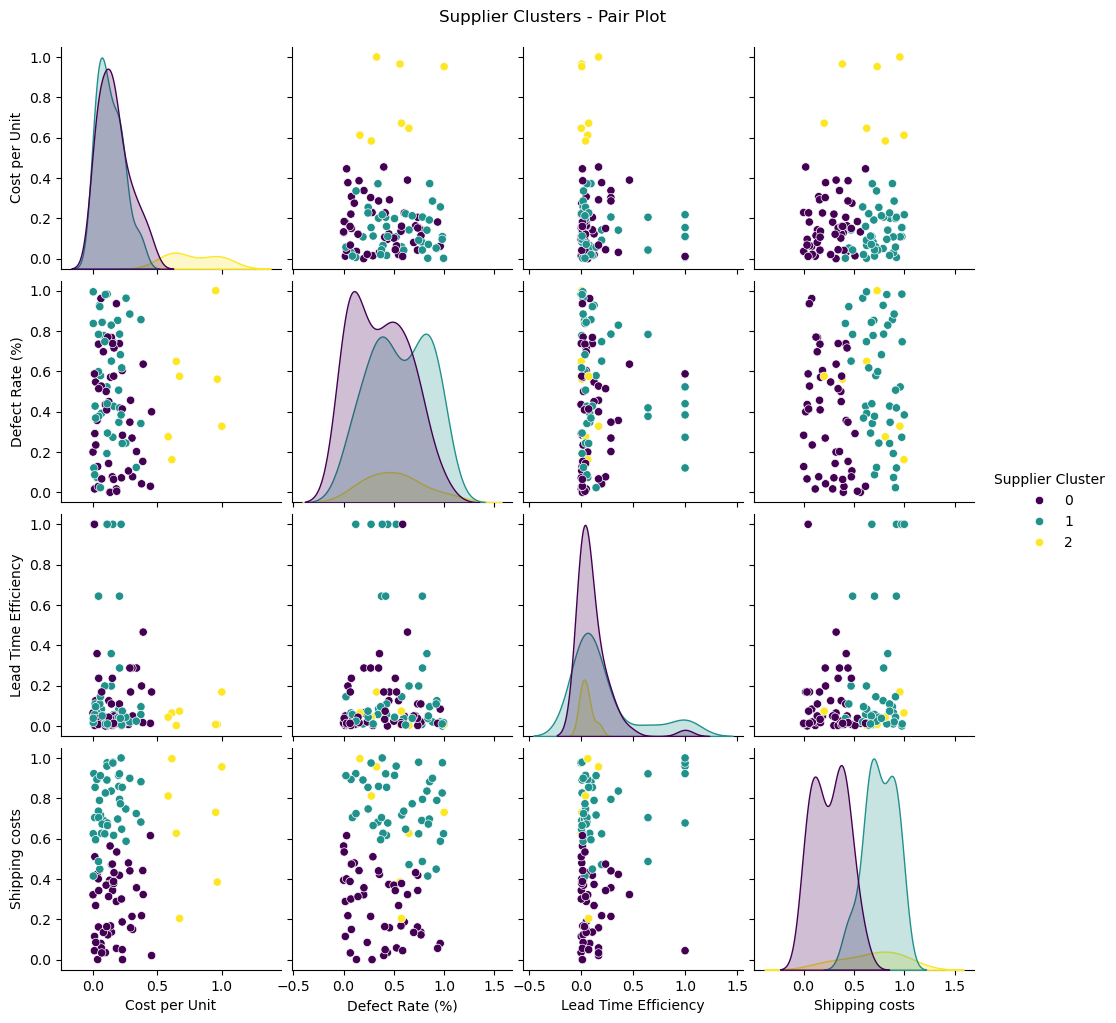

In [18]:
# Pair plot for a more comprehensive view
sns.pairplot(data, vars=cluster_features, hue="Supplier Cluster", palette="viridis", diag_kind="kde")
plt.suptitle("Supplier Clusters - Pair Plot", y=1.02)
plt.show()

## Conclusion

Our analysis revealed that Price and Lead Time are the most influential factors affecting supplier performance, highlighting the importance of cost management and efficient logistics. Additionally, features such as Availability and Manufacturing Costs also play significant roles, suggesting opportunities for inventory optimization and cost reduction.

However, the model's accuracy and overall performance indicate room for improvement, potentially through further feature engineering, hyperparameter tuning, or exploring more advanced algorithms. Moreover, conducting interpretability analysis using tools like SHAP or PDPs could provide deeper insights into the relationships between features and supplier performance.